
# Verify Response Curves (Overlay & Diagnostics)

This helper notebook:
- loads **per-channel response curves** from `../data/processed/response_curves/`  
- normalizes columns to `spend` and **pred_conversions** (preferring boosted predictions)  
- overlays all channels on one plot  
- computes quick diagnostics (spend range, mid-range marginal ROI)  
- saves an overlay PNG to `../assets/response_curves_overlay.png`

> Run this **after** Part-3 (Model Response Curves) so the CSVs exist.


In [1]:

from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

CURVE_DIR = Path("../data/processed/response_curves")
ASSETS_DIR = Path("../assets")
ASSETS_DIR.mkdir(parents=True, exist_ok=True)

print("Looking for curves in:", CURVE_DIR.resolve())
files = sorted(CURVE_DIR.glob("*_response_curve.csv"))
print("Found:", [f.name for f in files])


Looking for curves in: /Users/aravindanisetti/Desktop/2025 Training/Projects/oneplan-media-mix/data/processed/response_curves
Found: ['display_response_curve.csv', 'lineartv_response_curve.csv', 'social_response_curve.csv', 'streaming_response_curve.csv', 'youtube_response_curve.csv']


In [2]:

def load_curve(file_path: Path) -> pd.DataFrame:
    df = pd.read_csv(file_path)
    # tolerate stray index columns
    df = df.drop(columns=[c for c in df.columns if str(c).lower().startswith("unnamed")], errors="ignore")
    # choose a prediction column
    pred_cols = [c for c in df.columns if str(c).lower().startswith("pred_conversions")]
    boosted = [c for c in pred_cols if not str(c).lower().endswith("_lr")]
    if len(boosted) >= 1:
        pred_col = boosted[0]
    elif "pred_conversions_lr" in df.columns:
        pred_col = "pred_conversions_lr"
    else:
        # fallback: if exactly one numeric col besides spend, use it
        numeric_cols = [c for c in df.select_dtypes(include=[np.number]).columns]
        if "spend" in df.columns:
            numeric_cols = [c for c in numeric_cols if c != "spend"]
        pred_col = numeric_cols[0] if len(numeric_cols)==1 else pred_cols[0]
    out = df[["spend", pred_col]].copy()
    out.columns = ["spend","pred_conversions"]
    out = out.dropna().sort_values("spend").drop_duplicates(subset=["spend"])
    if len(out) < 2:
        raise ValueError(f"{file_path.name}: need >= 2 rows for interpolation")
    return out


In [3]:

# Load all curves and keep a dictionary keyed by channel name (derived from filename)
curves = {}
for f in files:
    ch = f.name.replace("_response_curve.csv", "")
    # preserve filename key to avoid mismatches
    try:
        dfc = load_curve(f)
        curves[ch] = dfc
    except Exception as e:
        print(f" Skipping {f.name}: {e}")
len(curves), list(curves.keys())[:10]


(5, ['display', 'lineartv', 'social', 'streaming', 'youtube'])

Saved overlay plot -> ../assets/response_curves_overlay.png


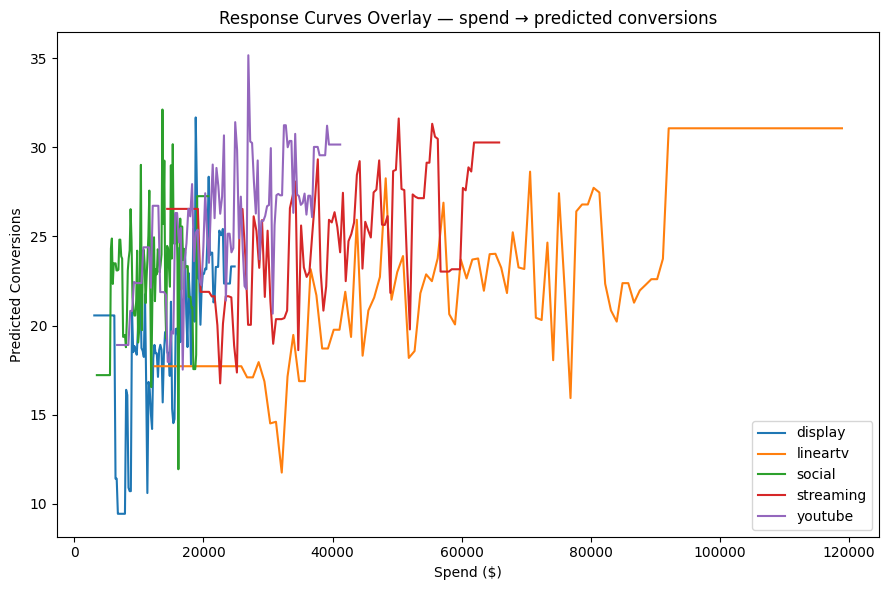

In [4]:

# Overlay plot
plt.figure(figsize=(9,6))
for ch, dfc in curves.items():
    plt.plot(dfc["spend"], dfc["pred_conversions"], label=ch)
plt.title("Response Curves Overlay — spend → predicted conversions")
plt.xlabel("Spend ($)")
plt.ylabel("Predicted Conversions")
plt.legend()
plt.tight_layout()
png_path = ASSETS_DIR / "response_curves_overlay.png"
plt.savefig(png_path, dpi=160)
print("Saved overlay plot ->", png_path)
plt.show()


In [5]:

# Diagnostics table: spend range and mid-range marginal ROI (finite-difference)
def marginal_roi(dfc: pd.DataFrame) -> float:
    x = dfc["spend"].values
    y = dfc["pred_conversions"].values
    if len(dfc) < 3:
        return np.nan
    mid = int(len(dfc) * 0.5)
    i0 = max(0, mid-1)
    i1 = min(len(dfc)-1, mid+1)
    dx = x[i1] - x[i0]
    if dx == 0:
        return np.nan
    return float((y[i1] - y[i0]) / dx)

rows = []
for ch, dfc in curves.items():
    smin, smax = float(dfc["spend"].min()), float(dfc["spend"].max())
    mroi = marginal_roi(dfc)
    rows.append([ch, smin, smax, mroi])
diag = pd.DataFrame(rows, columns=["channel_from_filename","spend_min","spend_max","mid_marginal_roi_per_$"])
diag.sort_values("mid_marginal_roi_per_$", ascending=False, inplace=True)
diag.reset_index(drop=True, inplace=True)
diag


,channel_from_filename,spend_min,spend_max,mid_marginal_roi_per_$
0,social,3487.480676,20754.520665,0.015713
1,display,3087.360701,24827.974091,0.003753
2,streaming,14376.663412,65797.093377,-0.000307
3,lineartv,12443.613962,118893.565597,-0.001229
4,youtube,6622.571033,41174.431085,-0.001796


In [6]:
for f in sorted(Path("../data/processed/response_curves").glob("*_response_curve.csv")):
    dfc = pd.read_csv(f)
    print(f.name, "min:", dfc['pred_conversions_xgb'].min(), "max:", dfc['pred_conversions_xgb'].max())

display_response_curve.csv min: 9.51017204426818 max: 24.971522872764865
lineartv_response_curve.csv min: 10.062049394652927 max: 29.49542176407785
social_response_curve.csv min: 18.31129969502999 max: 30.15924869498657
streaming_response_curve.csv min: 16.008448717678895 max: 29.410283793573416
youtube_response_curve.csv min: 18.044959310535745 max: 30.810961181176328
